In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [29]:
def calculate_norm_distance(
        tup1 : tuple, 
        tup2 : tuple
        )   -> float:
    
    x1, y1, z1 = tup1
    x2, y2, z2 = tup2

    sqx = (x2 - x1)**2
    sqy = (y2 - y1)**2
    sqz = (z2 - z1)**2
    
    distance = math.sqrt(sqx + sqy + sqz)
    return distance

def concat_with_unique_eventIDs(dfs):
    out = []
    offset = 0

    for i, df in tqdm(enumerate(dfs)):
        df = df.copy()
        df["eventID_local"] = df["eventID"]
        df["eventID"] = df["eventID"] + offset

        offset = df["eventID"].max() + 1
        out.append(df)

    return pd.concat(out, ignore_index=True)

# Df manipulations
def get_edep_df(df):
    df_edep = df[df['fEdep']>0]
    return df_edep

def get_positions(df):
    fX1_arr = np.array(df['fX1'])
    fY1_arr = np.array(df['fY1'])
    fZ1_arr = np.array(df['fZ1'])

    fX2_arr = np.array(df['fX2'])
    fY2_arr = np.array(df['fY2'])
    fZ2_arr = np.array(df['fZ2'])

    return fX1_arr, fY1_arr, fZ1_arr, fX2_arr, fY2_arr, fZ2_arr

# ER Analysis
def get_compton_spectrum(df, E_interval=[0,100]):

    cond1 = df['pdgID'] == 22
    cond2 = df['isEntry'] == 1
    cond3 = df['postProcName'] == 'compt'
    cond4 = (df['fK1'] < E_interval[1])
    cond5 = (df['fK1'] > E_interval[0])
    df_cond = df[cond1 & cond2 & cond3 & cond4 & cond5]

    # Get the delta KE of each such event
    fK1_arr = np.array(df_cond['fK1'])
    fK2_arr = np.array(df_cond['fK2'])
    #fEdep_arr = np.array(primary_compton_gammas_df['fEdep'])
    dKE = np.subtract(fK1_arr, fK2_arr)

    return fK1_arr, dKE

def get_compton_mfp(df, E_interval=[0,100]):

    cond1 = df['pdgID'] == 22
    cond2 = df['isEntry'] == 1
    cond3 = df['postProcName'] == 'compt'
    cond4 = (df['fK1'] < E_interval[1])
    cond5 = (df['fK1'] > E_interval[0])
    df_cond = df[cond1 & cond2 & cond3 & cond4 & cond5]

    # Get the incomine KE
    fK1_arr = np.array(df_cond['fK1'])

    # Get the backscatter angle
    fX1_arr = np.array(df_cond['fX1'])
    fY1_arr = np.array(df_cond['fY1'])
    fZ1_arr = np.array(df_cond['fZ1'])

    fX2_arr = np.array(df_cond['fX2'])
    fY2_arr = np.array(df_cond['fY2'])
    fZ2_arr = np.array(df_cond['fZ2'])

    distance_arr = np.array([
    calculate_norm_distance((x1, y1, z1), (x2, y2, z2))
    for x1, y1, z1, x2, y2, z2 in zip(fX1_arr, fY1_arr, fZ1_arr, fX2_arr, fY2_arr, fZ2_arr)])

    return fK1_arr, distance_arr

def fiducialise_df(df, xint, yint, zint):

    condx1 = (df['fX1'] < xint[1])
    condx2 = (df['fX1'] > xint[0])
    condy1 = (df['fY1'] < yint[1])
    condy2 = (df['fY1'] > yint[0])
    condz1 = (df['fZ1'] < zint[1])
    condz2 = (df['fZ1'] > zint[0])

    df_cond = df[condx1 & condx2 & condy1 & condy2 & condz1 & condz2]

    return df_cond


def get_ER_edeps(df):
    
    df_edeps = get_edep_df(df)
    df_edeps_11 = df_edeps[df['pdgID']==11]
    df_edeps_22 = df_edeps[df['pdgID']==22]

    events = len(df_edeps_11) + len(df_edeps_22)
    edep_tot = np.sum(np.array(df_edeps_11['fEdep'])) + np.sum(np.array(df_edeps_22['fEdep'])),2
    
    return edep_tot, events

In [25]:
dfs = []
for i in tqdm(range(1, 62)): # 0.61 of the df is about 10 mins (a little more than 600 secs for 10e7 activity)
    path = f"/storage/xenon/nadavh/SimpleCube/proc/Cobalt60_{i:04d}.parquet"
    dfs.append(pd.read_parquet(path))

df = concat_with_unique_eventIDs(dfs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [01:35<00:00,  1.57s/it]
61it [00:19,  3.17it/s]


## Spatial Distributions of Event

In [ ]:
df_fid = fiducialise_df(df, [35, 45], [-5, 5], [0, 10]) # Whole cube including surface
edep_tot, events = get_ER_edeps(df_fid)
print(edep_tot)
print(events)

In [19]:
df_fid = fiducialise_df(df, [35.5, 44.5], [-4.5, 4.5], [0.5, 9.5]) # Without 1/2mm of surface
edep_tot, events = get_ER_edeps(df_fid)
print(edep_tot)
print(events)

/tmp/ipykernel_2248474/2650693521.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_11 = df_edeps[df_fid['pdgID']==11]
/tmp/ipykernel_2248474/2650693521.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_22 = df_edeps[df_fid['pdgID']==22]


(5656208.960050078, 2)
18478900


In [23]:
df_fid = fiducialise_df(df, [39.5, 40.5], [-0.5, 0.5], [4.5, 5.5]) # Central 1mm^3
edep_tot, events = get_ER_edeps(df_fid)
print(edep_tot)
print(events)

(8787.397139583007, 2)
23500


/tmp/ipykernel_2248474/2650693521.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_11 = df_edeps[df_fid['pdgID']==11]
/tmp/ipykernel_2248474/2650693521.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_22 = df_edeps[df_fid['pdgID']==22]


/tmp/ipykernel_2248474/3465096185.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_11 = df_edeps[df_fid['pdgID']==11]
/tmp/ipykernel_2248474/3465096185.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_22 = df_edeps[df_fid['pdgID']==22]
/tmp/ipykernel_2248474/3465096185.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_11 = df_edeps[df_fid['pdgID']==11]
/tmp/ipykernel_2248474/3465096185.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_edeps_22 = df_edeps[df_fid['pdgID']==22]


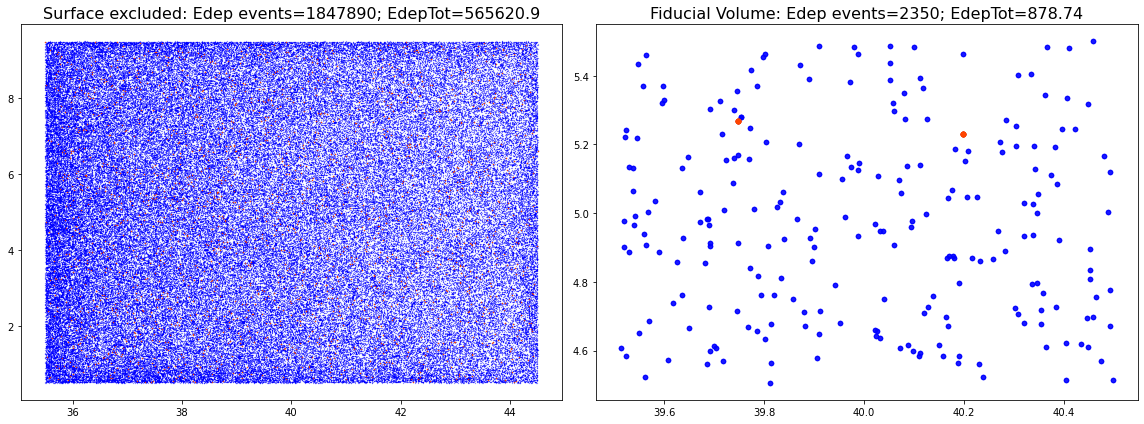

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# --- Fiducialise --- #
df_fid = fiducialise_df(df, [38.5, 44.5], [-4.5, 4.5], [0.5, 9.5])

df_edeps = get_edep_df(df_fid)
df_edeps_11 = df_edeps[df_fid['pdgID']==11]
df_edeps_22 = df_edeps[df_fid['pdgID']==22]

events = len(df_edeps_11) + len(df_edeps_22)
edep_tot = np.round(np.sum(np.array(df_edeps_11['fEdep'])) + np.sum(np.array(df_edeps_22['fEdep'])),2)

ax1.set_title(f"Surface excluded: Edep events={events}; EdepTot={edep_tot}", fontsize=16)

s = 0.01

x1, y1, z1, x2, y2, z2 = get_positions(df_edeps_11)
ax1.scatter(x1, z1, s=s, color='blue', alpha=0.2)

x1, y1, z1, x2, y2, z2 = get_positions(df_edeps_22)
ax1.scatter(x1, z1, s=s, color='orangered')

# --- Fiducialise --- #
df_fid = fiducialise_df(df, [39.5, 40.5], [-0.5, 0.5], [4.5, 5.5])

df_edeps = get_edep_df(df_fid)
df_edeps_11 = df_edeps[df_fid['pdgID']==11]
df_edeps_22 = df_edeps[df_fid['pdgID']==22]

events = len(df_edeps_11) + len(df_edeps_22)
edep_tot = np.round(np.sum(np.array(df_edeps_11['fEdep'])) + np.sum(np.array(df_edeps_22['fEdep'])),2)

ax2.set_title(f"Fiducial Volume: Edep events={events}; EdepTot={edep_tot}", fontsize=16)

s = 20

x1, y1, z1, x2, y2, z2 = get_positions(df_edeps_11)
ax2.scatter(x1, z1, s=s, color='blue', alpha=0.2)

x1, y1, z1, x2, y2, z2 = get_positions(df_edeps_22)
ax2.scatter(x1, z1, s=s, color='orangered')

plt.tight_layout()

In [22]:
df_fid = fiducialise_df(df, [35.5, 44.5], [-4.5, 4.5], [0.5, 9.5])
df_fid

,eventID,pdgID,isEntry,preProcName,postProcName,creatorProc,fX1,fY1,fZ1,fX2,fY2,fZ2,fK1,fK2,fEdep,eventID_local
38,948,22,0,compt,Transportation,Radioactivation,43.444378,4.038006,5.736132,45.000000,4.398417,7.001696,0.874049,0.874049,0.000000,948
39,948,11,0,NA,eIoni,compt,43.444378,4.038006,5.736132,43.596813,4.023426,5.615037,0.299178,0.000000,0.299178,948
120,2633,22,0,compt,Transportation,Radioactivation,40.405804,-1.482600,8.024902,40.325512,-5.000000,8.082698,0.360171,0.360171,0.000000,2633
121,2633,11,0,NA,eIoni,compt,40.405804,-1.482600,8.024902,41.193584,-1.266423,8.176228,0.813056,0.226920,0.586136,2633
122,2633,11,0,eIoni,eIoni,compt,41.193584,-1.266423,8.176228,41.234512,-1.289556,8.293232,0.226920,0.000000,0.226920,2633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432542411,9999989485,22,0,compt,Transportation,Radioactivation,37.308140,0.166881,4.033601,45.000000,-0.627557,0.940335,0.916263,0.916263,0.000000,99997702
432542412,9999989485,11,0,NA,eIoni,compt,37.308140,0.166881,4.033601,37.394009,0.191719,4.158685,0.256963,0.000000,0.256963,99997702
432542494,9999991414,22,0,compt,Transportation,Radioactivation,36.975197,-4.312684,8.096656,37.426628,-5.000000,8.657648,0.640784,0.640784,0.000000,99999631
432542495,9999991414,11,0,NA,msc,compt,36.975197,-4.312684,8.096656,37.236420,-4.232569,7.904977,0.532443,0.345707,0.186736,99999631


In [27]:
df

,eventID,pdgID,isEntry,preProcName,postProcName,creatorProc,fX1,fY1,fZ1,fX2,fY2,fZ2,fK1,fK2,fEdep,eventID_local
0,684,11,1,Transportation,msc,Radioactivation,35.000000,-2.759294,5.269849,35.001263,-2.759092,5.270172,0.063136,0.062262,0.000874,684
1,684,11,0,msc,msc,Radioactivation,35.001263,-2.759092,5.270172,35.002357,-2.758993,5.270156,0.062262,0.060978,0.001284,684
2,684,11,0,msc,msc,Radioactivation,35.002357,-2.758993,5.270156,35.003700,-2.759233,5.269593,0.060978,0.057888,0.003090,684
3,684,11,0,msc,msc,Radioactivation,35.003700,-2.759233,5.269593,35.005352,-2.759309,5.268697,0.057888,0.055402,0.002486,684
4,684,11,0,msc,msc,Radioactivation,35.005352,-2.759309,5.268697,35.007973,-2.760444,5.267593,0.055402,0.052543,0.002859,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263850920,6099994651,11,0,NA,msc,compt,36.975197,-4.312684,8.096656,37.236420,-4.232569,7.904977,0.532443,0.345707,0.186736,99999631
263850921,6099994651,11,0,msc,eIoni,compt,37.236420,-4.232569,7.904977,37.397678,-4.174966,7.731053,0.345707,0.000000,0.345707,99999631
263850922,6099994936,11,1,Transportation,msc,Radioactivation,43.078945,1.132985,10.000000,43.079487,1.133092,9.999988,0.041669,0.041251,0.000418,99999916
263850923,6099994936,11,0,msc,msc,Radioactivation,43.079487,1.133092,9.999988,43.080067,1.133154,9.999990,0.041251,0.040275,0.000976,99999916
